# PR_8.1 Regressiemodellen in Machine Learning

## Opdracht

Great Outdoors wil graag weten hoeveel zij gaat verkopen (afhankelijke variabele) in het volgende jaar.
- Bedenk met welke onafhankelijke variabelen dit naar verwachting het beste voorspeld kan worden en zet deze samen met de afhankelijke variabele in één DataFrame.
- Pas waar nodig Dummy Encoding toe.
- Snijd dit DataFrame horizontaal en verticaal op de juiste manier.
- Train het regressiemodel.
- Evalueer de performance van je getrainde regressiemodel.

![Splitsprocess Train- en Testdata sets](../Assets/Week%208/Splitsprocess.jpg) 

### Onafhankelijke variabelen

1. Order_Date in Order_Header
2. Order_Number in order_Header

### Afhankelijke variabele 
1. Quantity

## Implementatie

### Library Imports

In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

import seaborn as seabornInstance 

import numpy
import sqlite3
import csv
import pyodbc


### Data import en samenvoeging

In [2]:
sales_con = None
crm_con = None
staff_con = None
GO_SALES_PRODUCT_FORECASTData = None
GO_SALES_INVENTORY_LEVELSData = None



try : 
        sales_con = sqlite3.connect("../Assets/Week 2/go_sales.sqlite")
        print("Connected to go_sales sqlite.")


        crm_con = sqlite3.connect("../Assets/Week 2/go_crm.sqlite")
        print("Connected to go_crm sqlite.")


        staff_con = sqlite3.connect("../Assets/Week 2/go_staff.sqlite")
        print("Connected to go_staff sqlite.")

        GO_SALES_PRODUCT_FORECASTData = pd.read_csv("../Assets/Week 2/GO_SALES_PRODUCT_FORECASTData.csv")
        print("Connected to GO_SALES_PRODUCT_FORECASTData")

        GO_SALES_INVENTORY_LEVELSData = pd.read_csv("../Assets/Week 2/GO_SALES_INVENTORY_LEVELSData.csv", header=0, index_col=False)
        print("Connected to GO_SALES_INVENTORY_LEVELSData.csv")


except sqlite3.Error as error: 
        print("Failed to read data from sqlite table", error)

DataWarehouse_con = None

try : 
        pass
except : 
        pass




Connected to go_sales sqlite.
Connected to go_crm sqlite.
Connected to go_staff sqlite.
Connected to GO_SALES_PRODUCT_FORECASTData
Connected to GO_SALES_INVENTORY_LEVELSData.csv


In [3]:
global product
product = pd.read_sql_query("SELECT * FROM {}".format("product"),sales_con)
product = product[product.columns.drop(list(product.filter(regex="TRIAL")))]

global product_type
product_type = pd.read_sql_query("SELECT * FROM {}".format("product_type"),sales_con)
product_type = product_type[product_type.columns.drop(list(product_type.filter(regex="TRIAL")))]

global product_line
product_line = pd.read_sql_query("SELECT * FROM {}".format("product_line"),sales_con)
product_line = product_line[product_line.columns.drop(list(product_line.filter(regex="TRIAL")))]

global order_header
order_header = pd.read_sql_query("SELECT * FROM {}".format("order_header"),sales_con)
order_header = order_header[order_header.columns.drop(list(order_header.filter(regex="TRIAL")))]

global order_details
order_details = pd.read_sql_query("SELECT * FROM {}".format("order_details"),sales_con)
order_details = order_details[order_details.columns.drop(list(order_details.filter(regex="TRIAL")))]

In [4]:
dataset = pd.merge(order_header, order_details, left_on="ORDER_NUMBER", how="inner", right_on="ORDER_NUMBER")
dataset = pd.merge(dataset, product, left_on="PRODUCT_NUMBER", how="inner", right_on="PRODUCT_NUMBER")



dataset = dataset.convert_dtypes()
dataset["PRODUCT_NUMBER"] = dataset["PRODUCT_NUMBER"].astype(int)
dataset["ORDER_METHOD_CODE"] = dataset["ORDER_METHOD_CODE"].astype(int)
dataset["PRODUCT_TYPE_CODE"] = dataset["PRODUCT_TYPE_CODE"].astype(int)
dataset["UNIT_COST"] = dataset["UNIT_COST"].astype(float)
dataset["UNIT_SALE_PRICE"] = dataset["UNIT_SALE_PRICE"].astype(float)
dataset["UNIT_PRICE"] = dataset["UNIT_PRICE"].astype(float)
dataset["PRODUCTION_COST"] = dataset["PRODUCTION_COST"].astype(float)


# dataset["ORDER_DATE"] = pd.to_datetime(dataset["ORDER_DATE"]).dt.date

# probeer lijst van unieke retailer_names op te vragen en te mappen naar int voor in regressiemodel
retailers = pd.DataFrame(dataset["RETAILER_NAME"])
retailers = retailers.drop_duplicates()
retailers["RETAILER_ID"] = pd.factorize(retailers['RETAILER_NAME'].tolist())[0]



dataset = pd.merge(dataset, retailers, left_on="RETAILER_NAME", how="inner", right_on="RETAILER_NAME")

dataset = dataset.loc[:,[
    # "ORDER_DATE",
    "ORDER_METHOD_CODE",
    # "PRODUCT_NUMBER",
    # "PRODUCT_TYPE_CODE",
    "QUANTITY", 
    "UNIT_COST",
    "UNIT_PRICE",
    "UNIT_SALE_PRICE", 
    "PRODUCTION_COST"
    # "RETAILER_ID"
    ]
                      ]
# dataset["YEAR"] = pd.DatetimeIndex(dataset["ORDER_DATE"]).year
# dataset["MONTH"] = pd.DatetimeIndex(dataset["ORDER_DATE"]).month
# dataset = dataset.drop(["ORDER_DATE"], axis=1)

# dataset = dataset.groupby(["PRODUCT_NUMBER","YEAR","MONTH"]).sum()

# dataset = dataset.loc[(dataset["YEAR"]==2020),:]
# dataset = dataset.loc[(dataset["YEAR"]==2021),:]
# dataset = dataset.loc[(dataset["YEAR"]==2022),:]

print(dataset.dtypes)
print()
print(dataset.count())

dataset = dataset.loc[(dataset["QUANTITY"]<=800),:]

display(dataset)


ORDER_METHOD_CODE      int32
QUANTITY               Int64
UNIT_COST            float64
UNIT_PRICE           float64
UNIT_SALE_PRICE      float64
PRODUCTION_COST      float64
dtype: object

ORDER_METHOD_CODE    43063
QUANTITY             43063
UNIT_COST            43063
UNIT_PRICE           43063
UNIT_SALE_PRICE      43063
PRODUCTION_COST      43063
dtype: int64


C:\Users\Anthony Delgado\AppData\Local\Temp\ipykernel_56280\2469119271.py:21: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  retailers["RETAILER_ID"] = pd.factorize(retailers['RETAILER_NAME'].tolist())[0]


,ORDER_METHOD_CODE,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,PRODUCTION_COST
0,7,100,9.64,12.53,11.81,9.22
1,7,254,18.25,27.37,25.10,16.67
2,7,114,19.67,26.54,24.82,17.78
3,7,130,21.03,34.90,31.44,18.05
4,7,74,42.33,67.73,61.38,40.63
...,...,...,...,...,...,...
43058,5,64,19.00,38.00,33.25,19.00
43059,5,24,9.00,18.00,15.75,9.00
43060,5,40,40.00,80.00,70.00,40.00
43061,5,32,79.19,99.00,94.05,79.19


### One-hot encoding van onafhankelijke niet-numerieke variabelen

In [5]:
# pd.get_dummies(DATAFRAME.loc[:, [KOLOMMEN]])

### Verticaal en horizontaal snijden

In [6]:
X_dataset = dataset.drop("QUANTITY", axis=1)
Y_dataset = dataset.loc[:, ["QUANTITY"]]

display(X_dataset)

# X_dataset
# Y_dataset

,ORDER_METHOD_CODE,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,PRODUCTION_COST
0,7,9.64,12.53,11.81,9.22
1,7,18.25,27.37,25.10,16.67
2,7,19.67,26.54,24.82,17.78
3,7,21.03,34.90,31.44,18.05
4,7,42.33,67.73,61.38,40.63
...,...,...,...,...,...
43058,5,19.00,38.00,33.25,19.00
43059,5,9.00,18.00,15.75,9.00
43060,5,40.00,80.00,70.00,40.00
43061,5,79.19,99.00,94.05,79.19


In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    X_dataset,
    Y_dataset,
    test_size=0.15, #Percentage van de datasets dat opzij wordt gezet voor test doeleinden
    random_state=42 #zorgt ervoor dat resultaten consistent blijven. Arbitrair nummer
)
print(f"Length of x_train is {len(x_train)} \nLength of y_train is {len(y_train)}")
display(y_train)

Length of x_train is 36589 
Length of y_train is 36589


,QUANTITY
10594,12
34055,18
30852,20
3740,140
42571,8
...,...
6268,14
11287,44
38174,28
860,46


### Regressiemodel bouwen

In [8]:
reg_model = linear_model.LinearRegression()
reg_model = LinearRegression().fit(x_train, y_train)
reg_model

LinearRegression()

In [9]:
y_prediction = reg_model.predict(x_test)
display(pd.DataFrame(y_prediction))

,0
0,60.048945
1,17.944214
2,55.255741
3,57.384548
4,56.285981
...,...
6452,58.362290
6453,54.961233
6454,52.336168
6455,59.167727


In [10]:
prediction_DF = pd.DataFrame(y_prediction)
prediction_DF = prediction_DF.rename(columns= {0 : "Predicted Quantity"})

prediction_DF

,Predicted Quantity
0,60.048945
1,17.944214
2,55.255741
3,57.384548
4,56.285981
...,...
6452,58.362290
6453,54.961233
6454,52.336168
6455,59.167727


In [11]:
y_prediction_merge_test = pd.concat([y_test.reset_index()["QUANTITY"], prediction_DF], axis=1)
y_prediction_merge_test.loc[(y_prediction_merge_test["Predicted Quantity"].notna()),:]
y_prediction_merge_test = y_prediction_merge_test.loc[(y_prediction_merge_test["Predicted Quantity"]>0),:]
# y_prediction_merge_test

# y_prediction_merge_test = y_prediction_merge_test[:,:]

print(y_prediction_merge_test.dtypes)

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(y_prediction_merge_test)

QUANTITY                Int64
Predicted Quantity    float64
dtype: object
      QUANTITY  Predicted Quantity
0           46              60.049
1           12              17.944
2           22              55.256
3           48              57.385
4           16              56.286
5           20              55.201
6           40              46.501
7          464              59.253
8           34              57.107
9           42              56.853
10           6              13.203
11          20              55.438
12          18              42.940
13          30              59.098
14          16              53.271
15          90              58.859
16          30              56.635
17         144              60.932
18          70              57.177
19          18              57.667
20         170              60.835
21           8              58.217
22          14              40.559
23          56              57.909
24          48              49.928
25          12  

#### Grafiek schetsen

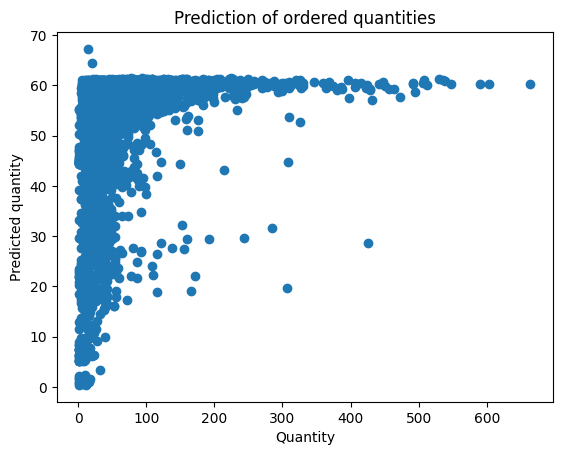

In [12]:
plt.scatter(y_prediction_merge_test["QUANTITY"], y_prediction_merge_test["Predicted Quantity"])
# plt.plot(x_train, reg_model.predict(x_train) )
# plt.plot(y_prediction_merge_test["QUANTITY"], y_prediction_merge_test["Predicted Quantity"])

plt.title('Prediction of ordered quantities')
plt.xlabel('Quantity')
plt.ylabel('Predicted quantity')


plt.show()

#### Model evalueren

##### Mean Squared Error

In [13]:
mean_squared_error(y_prediction_merge_test["QUANTITY"], y_prediction_merge_test["Predicted Quantity"])

2889.1190058320285

##### Mean Absolute Error

In [14]:
mean_absolute_error(y_prediction_merge_test["QUANTITY"], y_prediction_merge_test["Predicted Quantity"])

32.48236097837447

##### Root Mean Squared Error

In [15]:
numpy.sqrt(mean_squared_error(y_prediction_merge_test["QUANTITY"], y_prediction_merge_test["Predicted Quantity"]))

53.750525633076634

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 2.000e+00,
        2.000e+00, 2.000e+00, 1.000e+00, 3.000e+00, 4.000e+00, 3.000e+00,
        3.000e+00, 4.000e+00, 2.000e+00, 3.000e+00, 4.000e+00, 1.000e+00,
        2.000e+00, 7.000e+00, 7.000e+00, 6.000e+00, 6.000e+00, 6.000e+00,
        3.000e+00, 1.200e+01, 2.200e+01, 2.000e+01, 1.500e+01, 2.600e+01,
        4.200e+01, 5.400e+01, 5.400e+01, 8.000e+01, 8.400e+01, 1.120e+02,
        1.860e+02, 2.480e+02, 4.080e+02, 7.330e+02, 1.073e+03, 1.391e+03,
        1.265e+03, 3.980e+02]),
 array([-603.78808347, -590.60436133, -577.42063918, -564.23691704,
        -551.0531949 , -537.86947275, -524.68575061, -511.50202847,
        -498.31830632, -485.13458418, -471.95086204, -458.76713989,
        -445.58341775, -432.39969561, -419.21597346, -406.03225132,
        -392.84852918, -379.66480703, -366.48108489, -353.29736275,
        -340.1136406 , -326.92991846

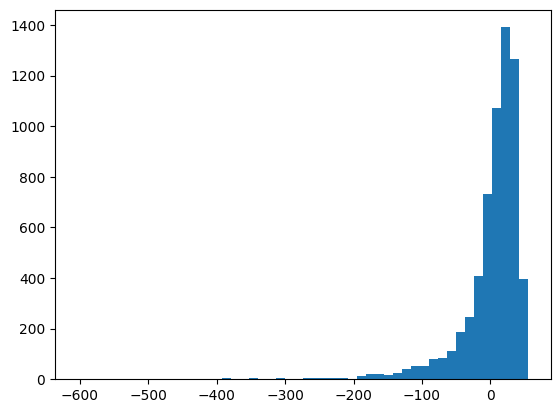

In [16]:
plt.hist(y_prediction_merge_test["Predicted Quantity"] - y_prediction_merge_test["QUANTITY"], bins=50)

## Poging 2

In [17]:
x = dataset[["ORDER_METHOD_CODE","UNIT_COST","UNIT_SALE_PRICE"]]#.values
y = dataset["QUANTITY"].values

C:\Users\Anthony Delgado\AppData\Local\Temp\ipykernel_56280\1164883159.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  seabornInstance.distplot(dataset['QUANTITY'])


<Axes: xlabel='QUANTITY', ylabel='Density'>

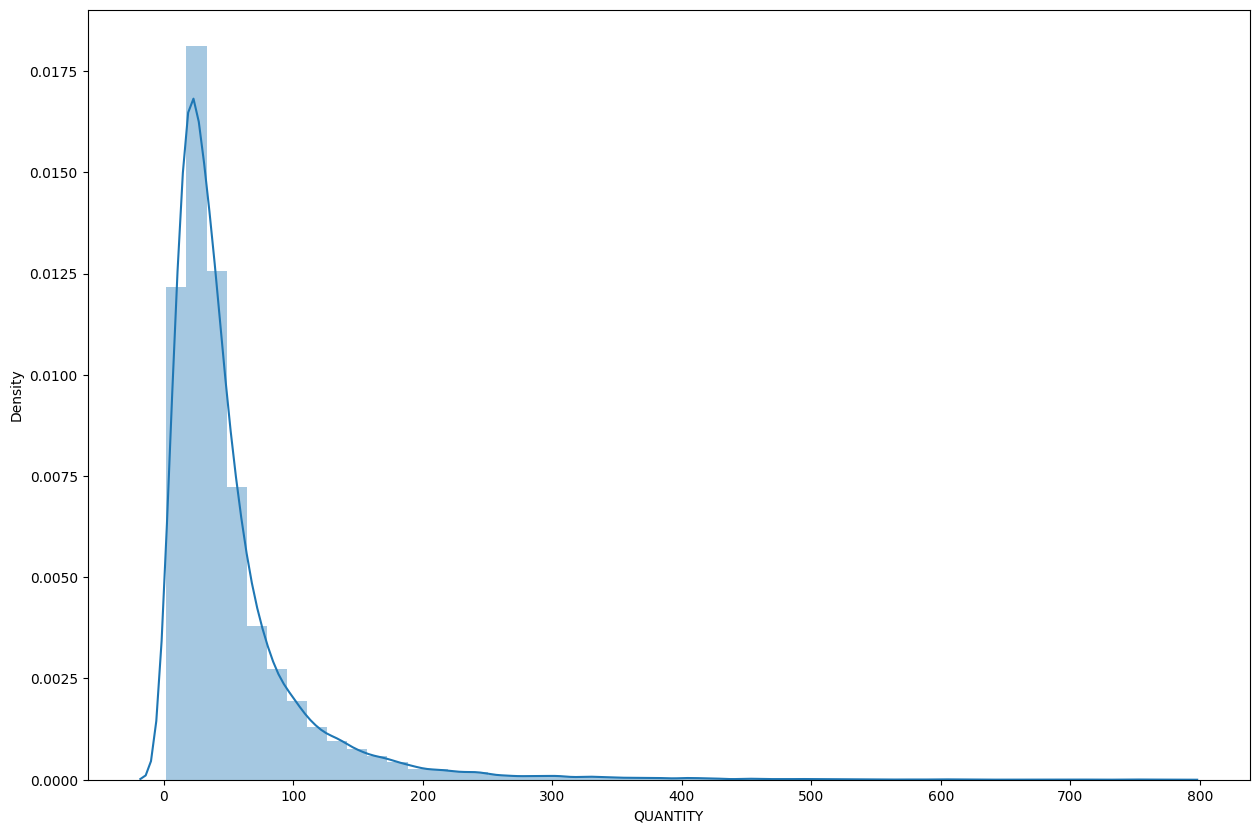

In [18]:
plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(dataset['QUANTITY'])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    x, 
    y, 
    test_size=0.2, 
    random_state=0
    )

In [20]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression()

In [21]:
coeff_df = pd.DataFrame(
    regressor.coef_, 
    x.columns 
    ,columns=['Coefficient']
                        )  
coeff_df


,Coefficient
ORDER_METHOD_CODE,0.145713
UNIT_COST,0.045203
UNIT_SALE_PRICE,-0.090916


In [31]:
y_pred = regressor.predict(X_test)

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df = df.loc[(df["Predicted"]>0),:]
df.to_csv('Predicted_Sales.csv', index=False)

df1 = df.head(25)
display(df1)
print(df.dtypes)

,Actual,Predicted
0,30,59.222169
1,90,59.454109
2,52,53.573403
3,28,56.388816
4,48,58.161709
5,6,18.628433
6,2,0.748635
7,68,58.440921
8,50,59.864254
9,24,53.998008


Actual         Int64
Predicted    float64
dtype: object


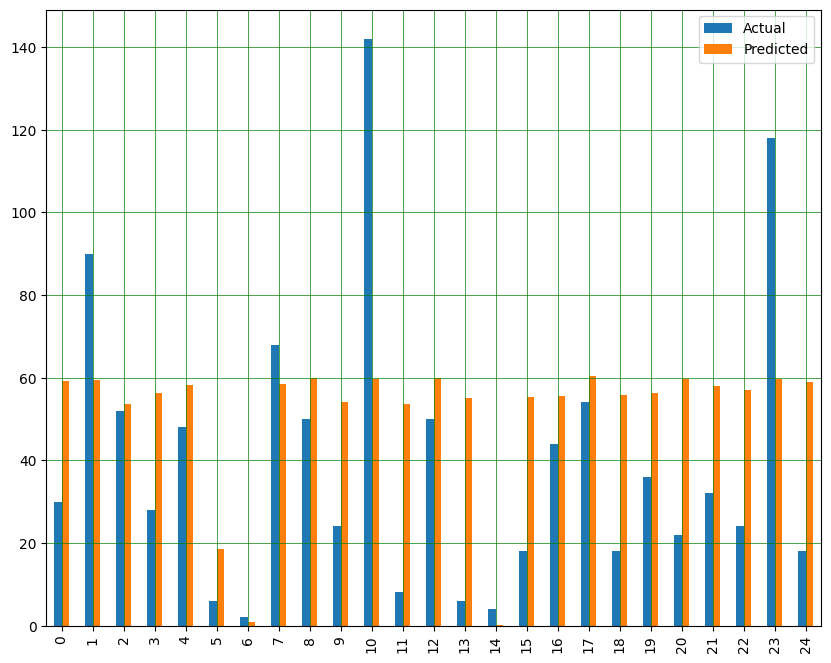

In [23]:
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

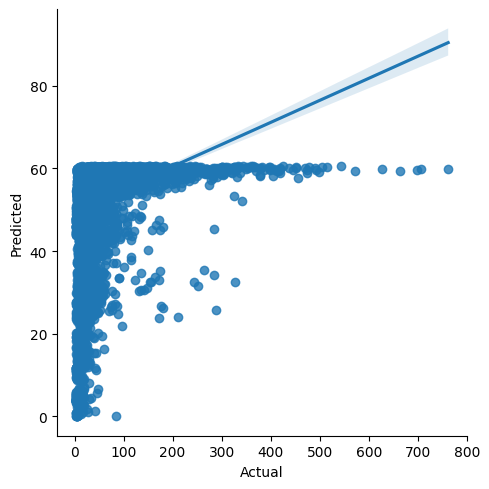

In [32]:
seabornInstance.lmplot(x="Actual", y="Predicted", data=df)

In [ ]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', numpy.sqrt(mean_squared_error(y_test, y_pred)))


Mean Absolute Error: 33.25783092439345
Mean Squared Error: 2991.5440624845714
Root Mean Squared Error: 54.6950094842717
